In [104]:
import catboost
import pandas as pd
import numpy as np
from typing import List
import pandas as pd
from scipy import stats
import datetime
import rpy2
import matplotlib.ticker as plticker
from functools import reduce
import seaborn as sns
from catboost import CatBoostRegressor
import time
import seaborn as sns
import ast
import numpy as np
from dateutil import parser
import xarray as xr
from kshape.core import kshape, zscore
from tslearn.clustering import KShape
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

In [146]:
df = pd.read_csv('Export\cdnow\cdnow_time_series_initial_2000.csv').rename(columns = {'id':'Unnamed: 0'})
df_freq = pd.read_csv('Export\cdnow\cdnow_frequency_2000.csv').drop(columns=['label'])
df_monet = pd.read_csv('Export\cdnow\cdnow_monetary_2000.csv').drop(columns=['label'])
df_recency = pd.read_csv('Export\cdnow\cdnow_recency_2000.csv').drop(columns=['label'])
df.head()

,Unnamed: 0,1997-01-01,1997-01-02,1997-01-03,1997-01-04,1997-01-05,1997-01-06,1997-01-07,1997-01-08,1997-01-09,...,1998-06-21,1998-06-22,1998-06-23,1998-06-24,1998-06-25,1998-06-26,1998-06-27,1998-06-28,1998-06-29,1998-06-30
0,6383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
df_freq.head()

,Unnamed: 0,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
0,6383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001949,0.001946,0.001942,0.001938,0.001934,0.001931,0.001927,0.001923,0.001919,0.001916
1,6146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001946,0.001942,0.001938,0.001934,0.001931,0.001927,0.001923,0.001919,0.001916,0.001912
2,5044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001931,0.001927,0.001923,0.001919,0.001916,0.001912,0.001908,0.001905,0.001901,0.001898
3,10377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002000,0.001996,0.001992,0.001988,0.001984,0.001980,0.001976,0.001972,0.001969,0.001965
4,6496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013645,0.013619,0.013592,0.013566,0.013540,0.013514,0.013487,0.013462,0.013436,0.013410


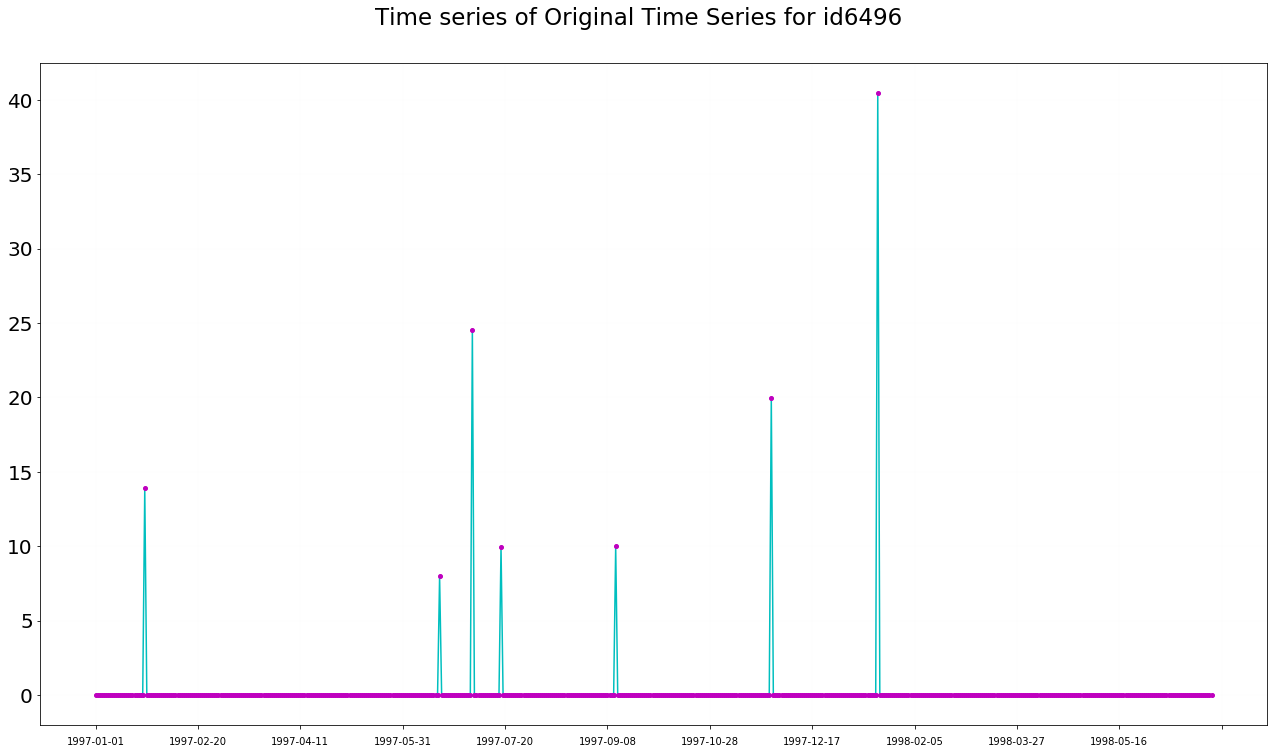

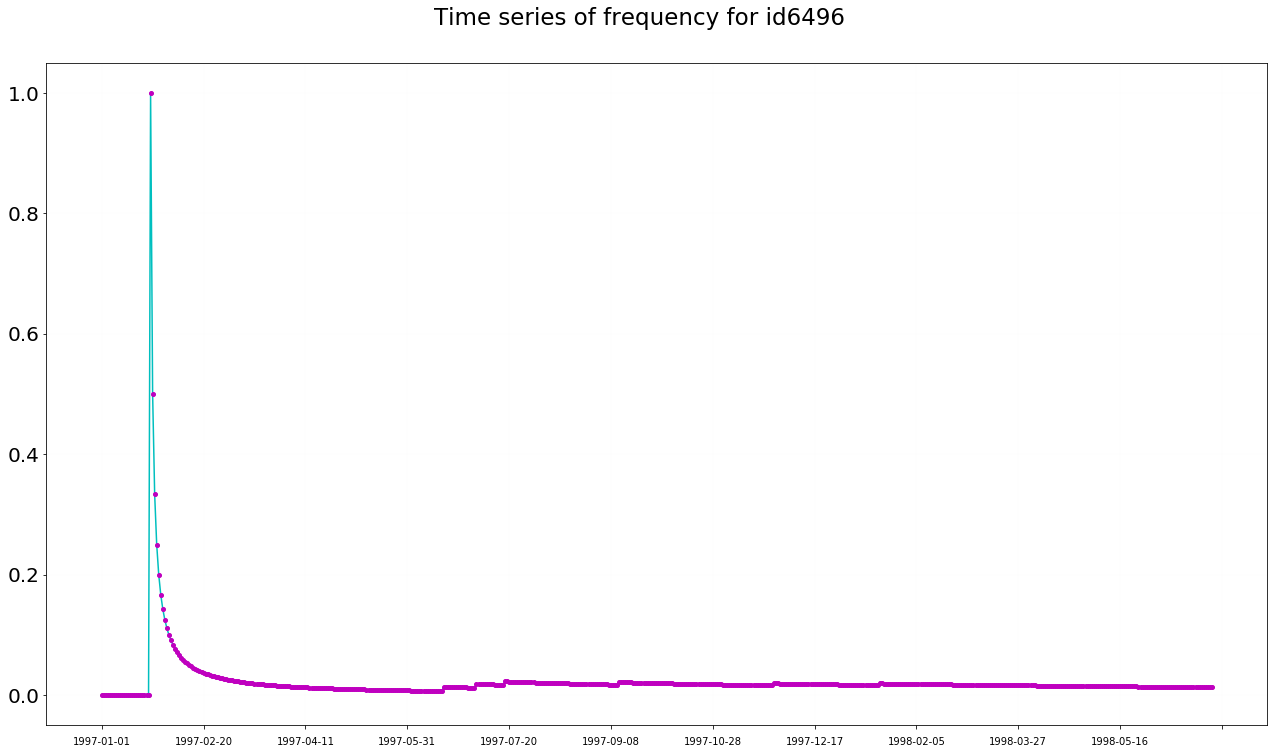

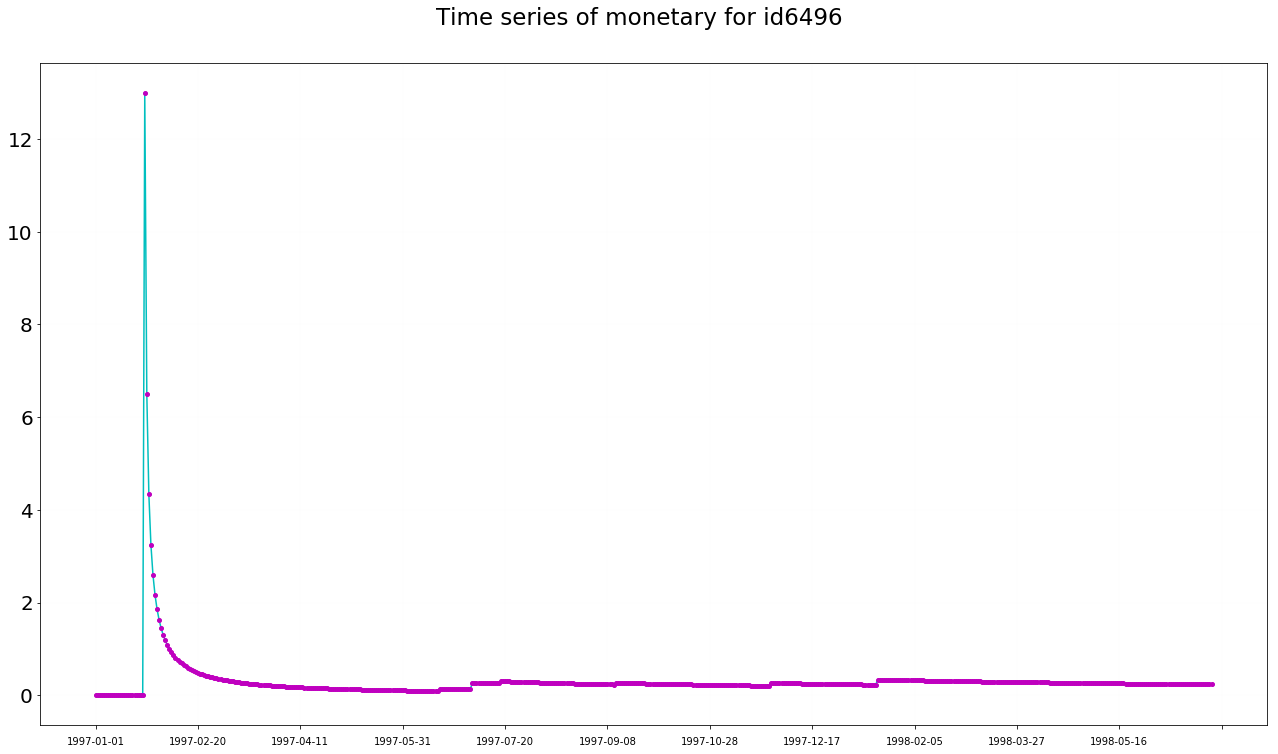

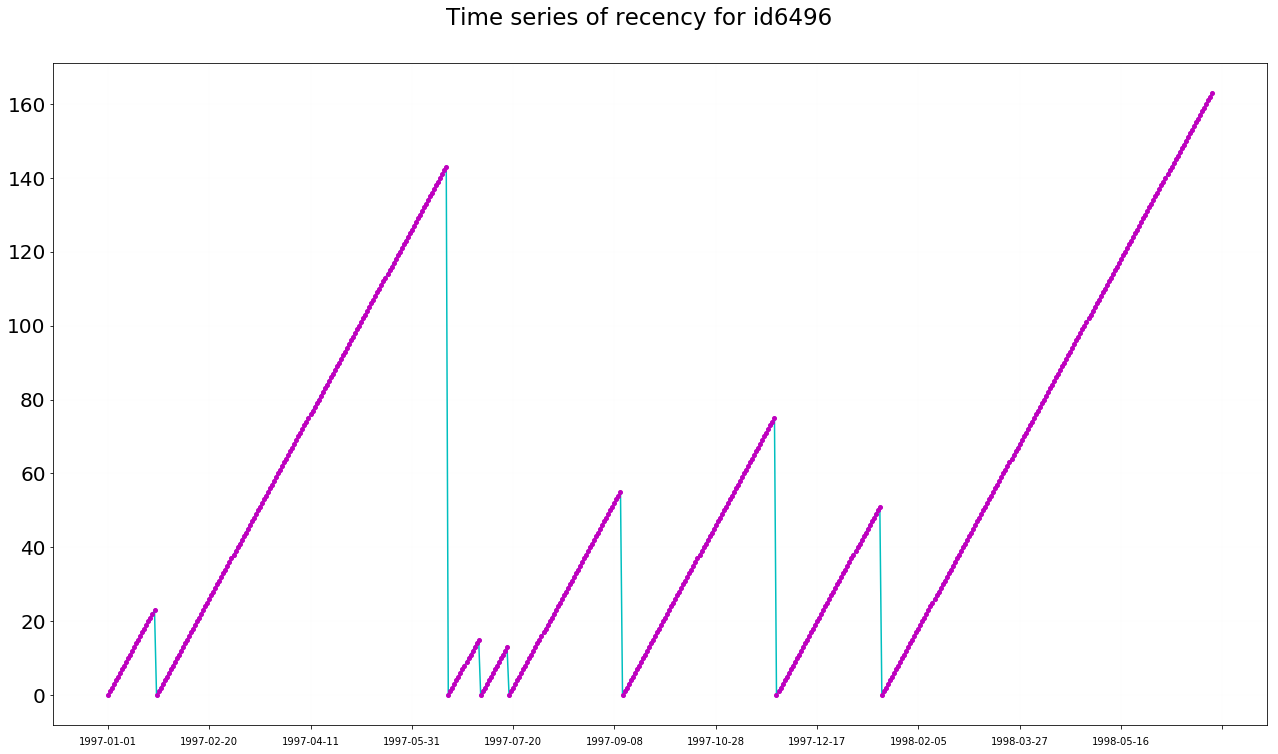

In [182]:
plot_one(6496,df,df.columns[1:],"Original Time Series")
plot_one(6496,df_freq,df.columns[1:],"frequency")
plot_one(6496,df_monet,df.columns[1:],"monetary")
plot_one(6496,df_recency,df.columns[1:],"recency")

In [181]:
def plot_one(uid, data,times, data_type):
    ts = np.where(np.isnan(data.loc[data["Unnamed: 0"]==uid].iloc[0,1:]), 0, data.loc[data["Unnamed: 0"]==uid].iloc[0,1:])
    #ts = data.loc[data["Unnamed: 0"]==uid].iloc[0,1:]
    tt = {'fontsize':20}    
    f, axs = plt.subplots(nrows=1, ncols=1,  figsize=(13,4))
    axs.plot(times, ts, '-o', c='c', 
                      markerfacecolor='m', mec = 'm', markersize=4)
    axs.grid(color='grey', linestyle='-', linewidth=0.02)
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.gcf().set_size_inches(18, 10)
    loc = plticker.MultipleLocator(base=50)
    plt.gca().xaxis.set_major_locator(loc)
    plt.grid(alpha=0.3)
    plt.suptitle('Time series of {0} for id{1}'.format(data_type, uid), y=1.05, fontsize= 23)
    plt.tight_layout()

In [184]:
df_centroids = pd.read_csv('Export\cdnow\cdnow_cluster_centroids_2000.csv')
df_centroids.head()

,Unnamed: 0,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
0,Centroid_for_recency_0,-1.083103,-1.077236,-1.071259,-1.065360,-1.059579,-1.053763,-1.047749,-1.041837,-1.036158,...,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242,-1.429242
1,Centroid_for_frequency_0,-0.257053,-0.257053,-0.257053,-0.257053,-0.257053,-0.257053,-0.257053,-0.257053,-0.257053,...,-0.231382,-0.232668,-0.233727,-0.234765,-0.236534,-0.237251,-0.237957,-0.238621,-0.239186,-0.239629
2,Centroid_for_monetary_0,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,...,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078,-0.234078
3,Centroid_for_recency_1,-0.716884,-0.708325,-0.695129,-0.683830,-0.672773,-0.659577,-0.647788,-0.635799,-0.627210,...,-1.292121,-1.292058,-1.291995,-1.291932,-1.291869,-1.291806,-1.291743,-1.291680,-1.291617,-1.291554
4,Centroid_for_frequency_1,-0.433645,-0.433645,-0.433645,-0.433645,-0.433645,-0.433645,-0.433645,-0.433645,15.753623,...,-0.414587,-0.415647,-0.417173,-0.417204,-0.417235,-0.417819,-0.419892,-0.421647,-0.422765,-0.422785


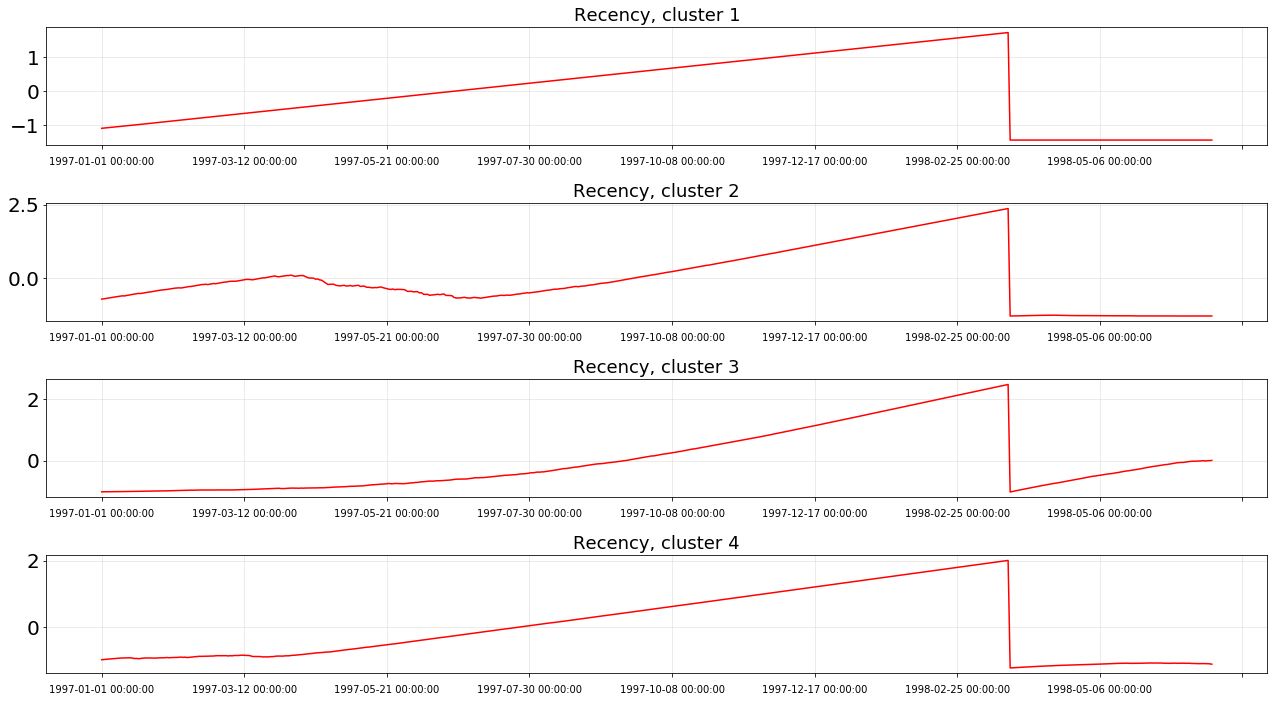

In [237]:
plt.figure()
for yi in range(4):
    plt.subplot(4, 1, 1 + yi)
    plt.plot(df_centroids.columns[1:],df_centroids.iloc[0+yi*3,:][1:].ravel(), "r-")
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.gcf().set_size_inches(18, 10)
    loc = plticker.MultipleLocator(base=70)
    plt.gca().xaxis.set_major_locator(loc)
    plt.grid(alpha=0.3)
    plt.title("Recency, cluster %d" % (yi + 1))
plt.tight_layout()
plt.show()

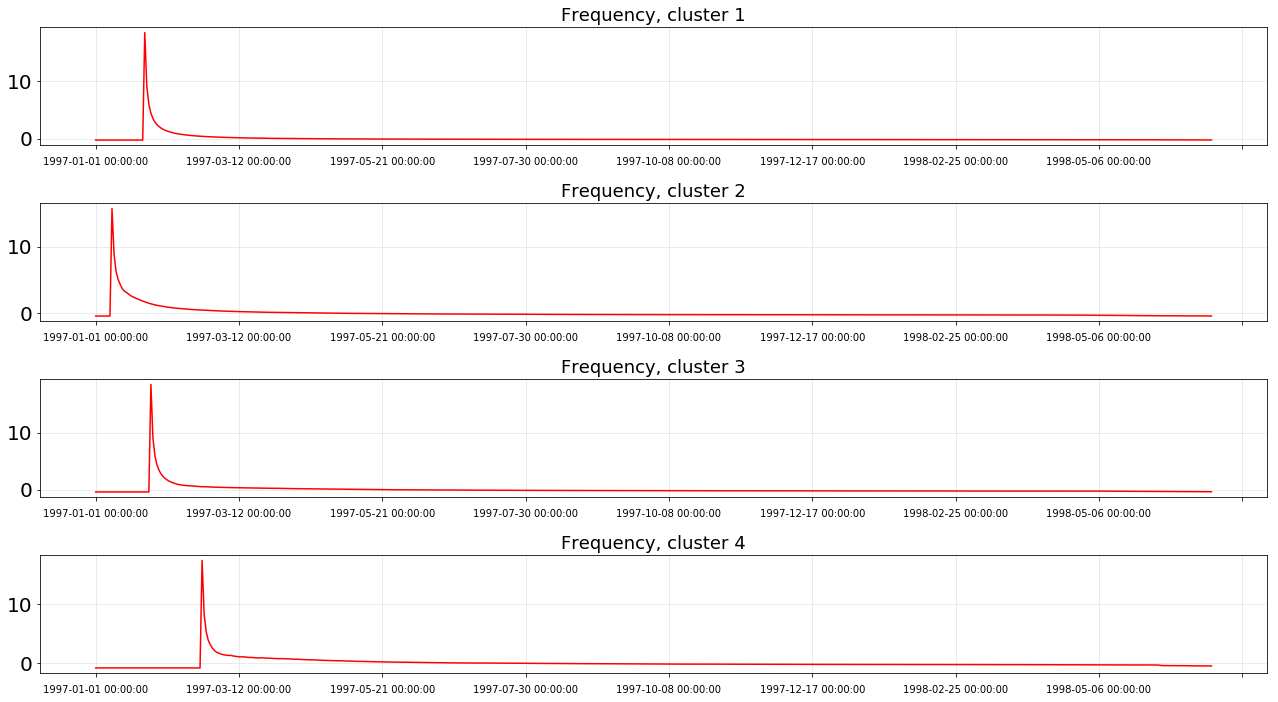

In [238]:
plt.figure()
for yi in range(4):
    plt.subplot(4, 1, 1 + yi)
    plt.plot(df_centroids.columns[1:],df_centroids.iloc[1+yi*3,:][1:].ravel(), "r-")
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.gcf().set_size_inches(18, 10)
    loc = plticker.MultipleLocator(base=70)
    plt.gca().xaxis.set_major_locator(loc)
    plt.grid(alpha=0.3)
    plt.title("Frequency, cluster %d" % (yi + 1))
plt.tight_layout()
plt.show()

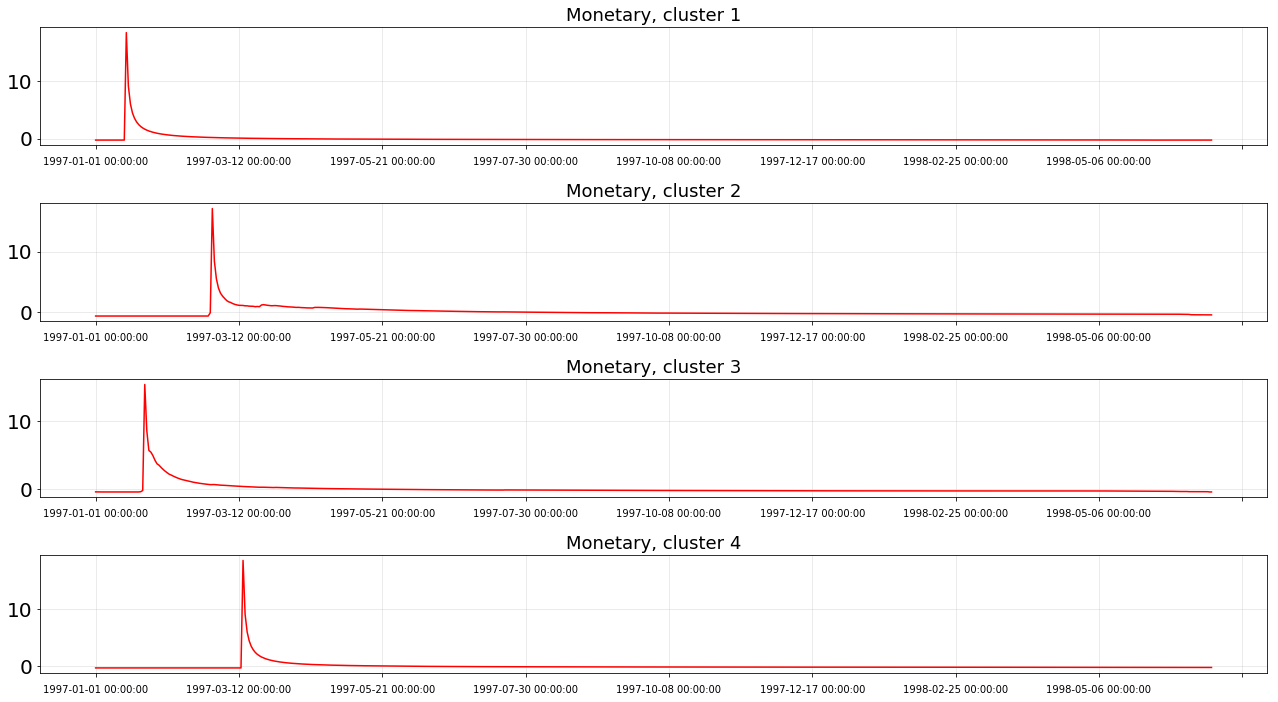

In [239]:
plt.figure()
for yi in range(4):
    plt.subplot(4, 1, 1 + yi)
    plt.plot(df_centroids.columns[1:],df_centroids.iloc[2+yi*3,:][1:].ravel(), "r-")
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.gcf().set_size_inches(18, 10)
    loc = plticker.MultipleLocator(base=70)
    plt.gca().xaxis.set_major_locator(loc)
    plt.grid(alpha=0.3)
    plt.title("Monetary, cluster %d" % (yi + 1))
plt.tight_layout()
plt.show()